# Welter



Wednesday, June 22, 2016  from Great Leap Brewing Co. with Greg H.

## Amplitude of variability and curve fitting for the ASASSN data surrouning ESPaDoNs Obs.


In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

## Use Aggregated ASASSN Data

In [3]:
import pandas as pd

The header contains 3 extraneous octothorpes "###".  Read the data just to get the columns.

In [4]:
fn = '../data/photometry/LkCa4_ASASSN_aggregated.dat'
dat = pd.read_csv(fn)

In [5]:
dat.head()

,JD,mean_mag,stddev,n_obs
0,2.455947e+06,12.84,0.01,1.0
1,2.455947e+06,12.75,0.01,1.0
2,2.455951e+06,12.65,0.01,1.0
3,2.455951e+06,12.64,0.01,1.0
4,2.455953e+06,13.04,0.01,2.0


## Bonus Grankin data from 2013

In [6]:
gr_bonus = pd.read_csv('../data/photometry/LkCa4_2013_grankin_bonus.dat', delim_whitespace=True)

In [7]:
gr_bonus.head()

,HJD+2456000,V_mag
0,537.5417,12.780
1,547.5133,12.819
2,577.5613,12.942
3,593.5458,12.821
4,595.5525,12.699


In [8]:
gr_bonus['HJD'] = gr_bonus['HJD+2456000'] + 2456000.0

No uncertainties provided, assume 0.01

In [9]:
gr_bonus['err'] = 0.01

## ESPaDoNs observations

In [10]:
#!cat ../data/photometry/ESPaDoNs_LkCa4_obsdates.csv
espadons_obsdates = pd.read_csv('../data/photometry/ESPaDoNs_LkCa4_obsdates.csv', sep='\s+')
espadons_obsdates['BJD'] =  espadons_obsdates['bjd-2456000'] + 2456000.0
espadons_obsdates

,bjd-2456000,Day,month,BJD
0,665.72044,8,1,2.456666e+06
1,666.85048,9,1,2.456667e+06
2,667.77270,10,1,2.456668e+06
3,668.86991,11,1,2.456669e+06
4,672.89947,15,1,2.456673e+06
5,673.84079,16,1,2.456674e+06
6,674.77460,17,1,2.456675e+06
7,675.73957,18,1,2.456676e+06
8,676.79539,19,1,2.456677e+06
9,677.86992,20,1,2.456678e+06


## Model the sparse lightcurve

Use both the Grankin bonus data and the ASASSN data

In [11]:
inds = (dat.JD > 2456520) & (dat.JD < 2456750)

x = np.append(dat.JD[inds].values, gr_bonus.HJD.values) 
y = np.append(dat.mean_mag[inds].values, gr_bonus.V_mag.values)
yerr = np.append(dat.stddev[inds].values, gr_bonus.err.values)

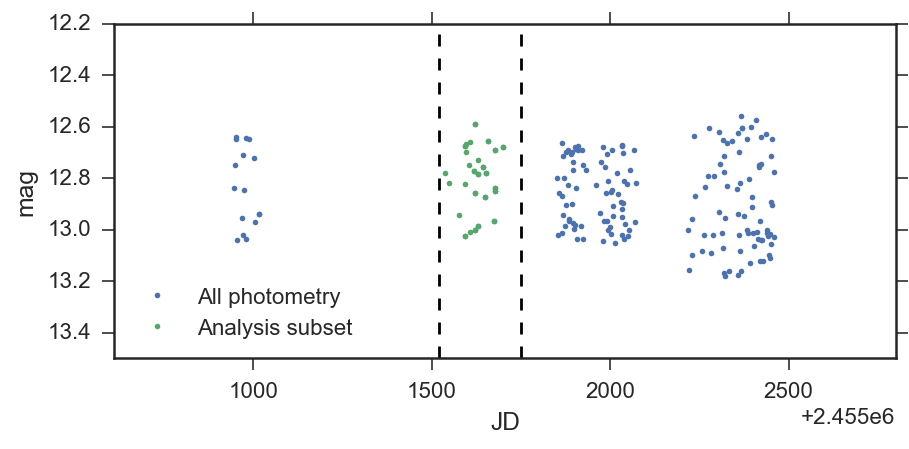

In [12]:
plt.figure(figsize=(7, 3))
plt.plot(dat.JD, dat.mean_mag, '.', label='All photometry')
plt.plot(x, y, '.', label='Analysis subset')
plt.ylim(13.5, 12.2)
plt.xlim(2455610, 2457800)
    
plt.vlines(2456520, 13.5, 12.2, linestyles='dashed')
plt.vlines(2456750, 13.5, 12.2, linestyles='dashed')
    
plt.legend(loc='lower left')
plt.xlabel('JD')
plt.ylabel('mag');

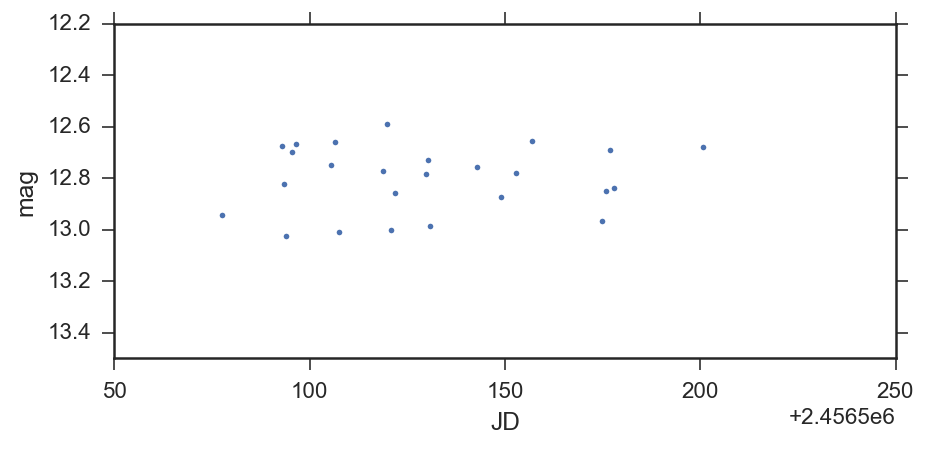

In [13]:
plt.figure(figsize=(7, 3))
plt.plot(x, y, '.', label='Analysis subset')
plt.ylim(13.5, 12.2)
plt.xlim(2456550, 2456750)

plt.xlabel('JD')
plt.ylabel('mag');

## Dial in the period

In [14]:
from astroML.time_series import multiterm_periodogram
from astroML.time_series import lomb_scargle

In [15]:
light_curve = pd.DataFrame({"time":x, "flux":y, "err":yerr})

In [16]:
def run_periodograms(light_curve, P_range=[0.1, 10], samples=10000):
    '''Returns periodograms for hardcoded subset of K2 Cycle 2 lightcurve'''
    x = light_curve.time.values
    y = light_curve.flux.values
    yerr = light_curve.err.values
    
    periods = np.linspace(P_range[0], P_range[1], samples)

    omega = 2.00*np.pi/periods

    P_M = multiterm_periodogram(x, y, yerr, omega)
    P_LS = lomb_scargle(x, y, yerr, omega)
    return (periods, P_M, P_LS)

In [17]:
from scipy.signal import argrelmax

In [18]:
def top_N_periods(periods, lomb_scargle_power, n=5):
    '''Returns the top N Lomb-Scargle periods, given a vector of the periods and values'''
    
    # Get all the local maxima
    all_max_i = argrelmax(lomb_scargle_power)
    max_LS = lomb_scargle_power[all_max_i]
    max_periods = periods[all_max_i]
    
    # Sort by the Lomb-Scale power
    sort_i = np.argsort(max_LS)
    
    # Only keep the top N periods
    top_N_LS = max_LS[sort_i][::-1][0:n]
    top_N_pers = max_periods[sort_i][::-1][0:n]
    
    return top_N_pers, top_N_LS

In [19]:
def plot_LC_and_periodograms(lc, periods, P_M, P_LS):
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.plot(lc.time, lc.flux, '.')
    plt.subplot(122)
    plt.step(periods, P_M, label='Multi-term periodogram')
    plt.step(periods, P_LS, label='Lomb Scargle')
    plt.legend()

In [20]:
lc = light_curve
periods, P_M, P_LS = run_periodograms(lc)

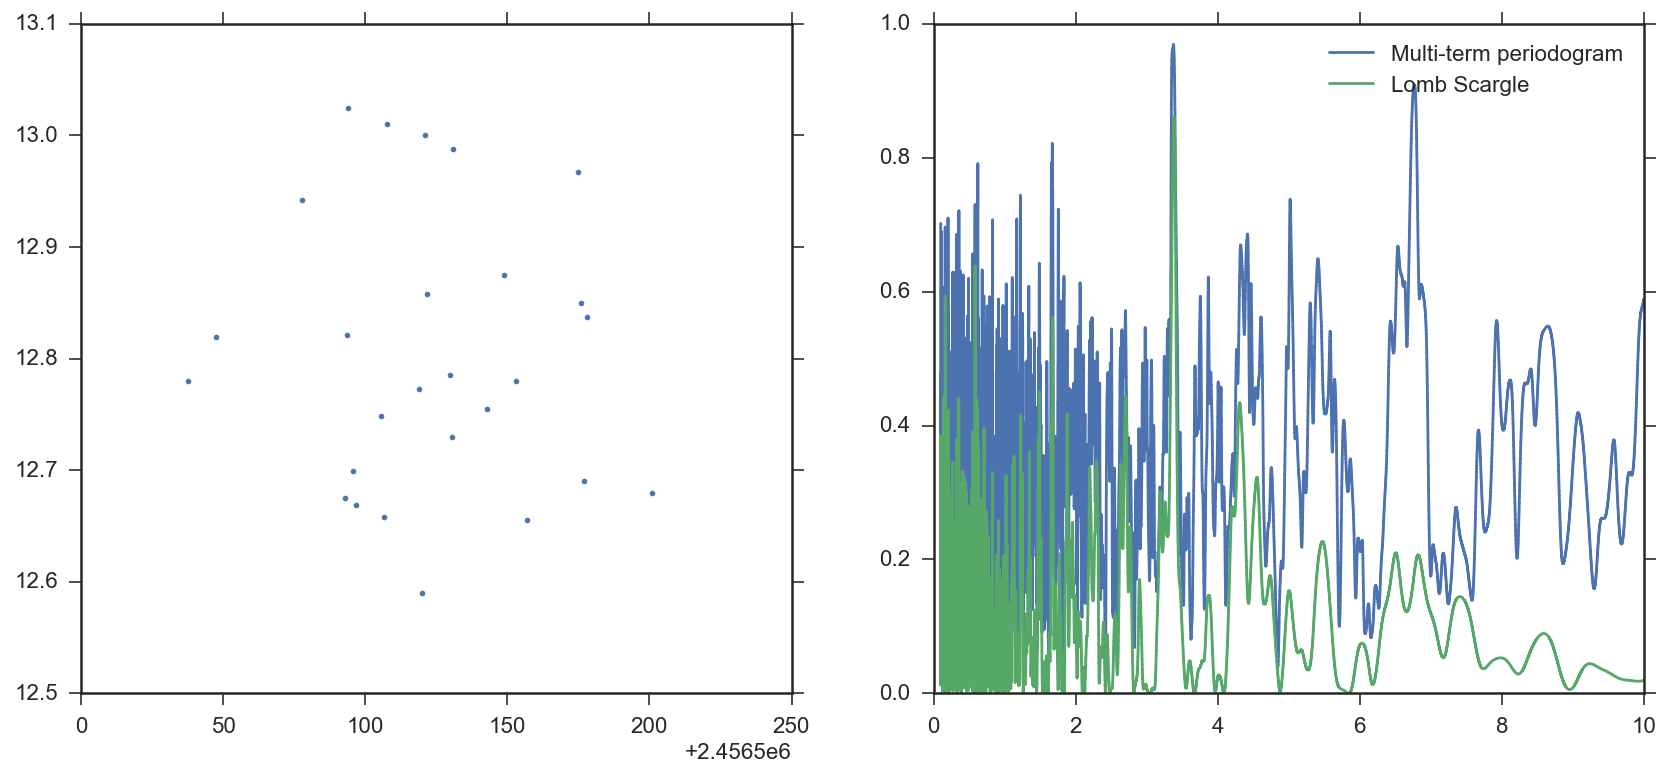

In [21]:
plot_LC_and_periodograms(lc, periods, P_M, P_LS)
plt.savefig('../results/periodgram_orig.pdf')

In [22]:
p_days_LS, X_sq_M = top_N_periods(periods, P_LS)
p_days_LS

array([ 3.38415842,  0.58514851,  0.16435644,  1.67623762,  1.49009901])

In [23]:
p_days_M, X_sq_LS = top_N_periods(periods, P_M)
p_days_M

array([ 3.37920792,  6.77029703,  1.67227723,  1.65940594,  0.62376238])

Surprisingly noisy, but I suppose it's relatively few periods...

In [24]:
periods_fine, P_M_fine, P_LS_fine = run_periodograms(lc, P_range=[3.3, 3.45])

In [25]:
p_days_M, X_sq_LS = top_N_periods(periods_fine, P_M_fine, n=1)
P_fit = p_days_M[0]

In [26]:
print('The period is {:.4f} days'.format(P_fit))

The period is 3.3791 days


## Fit the amplitude

In [27]:
sin_vector = np.sin(2.0*np.pi*x/P_fit)
cos_vector = np.cos(2.0*np.pi*x/P_fit)

A = np.concatenate((np.expand_dims(sin_vector, 1),
                    np.expand_dims(cos_vector, 1),
                    np.vander(x, 3)), axis=1)

ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

yfit = np.matmul(mean_w, A.T)

x_dense = np.arange(x.min(), x.max(), 0.01)

A_dense = np.concatenate((np.expand_dims(np.sin(2.0*np.pi*x_dense/P_fit), 1),
                    np.expand_dims(np.cos(2.0*np.pi*x_dense/P_fit), 1),
                    np.vander(x_dense, 3)), axis=1)

yfit_dense = np.matmul(mean_w, A_dense.T)

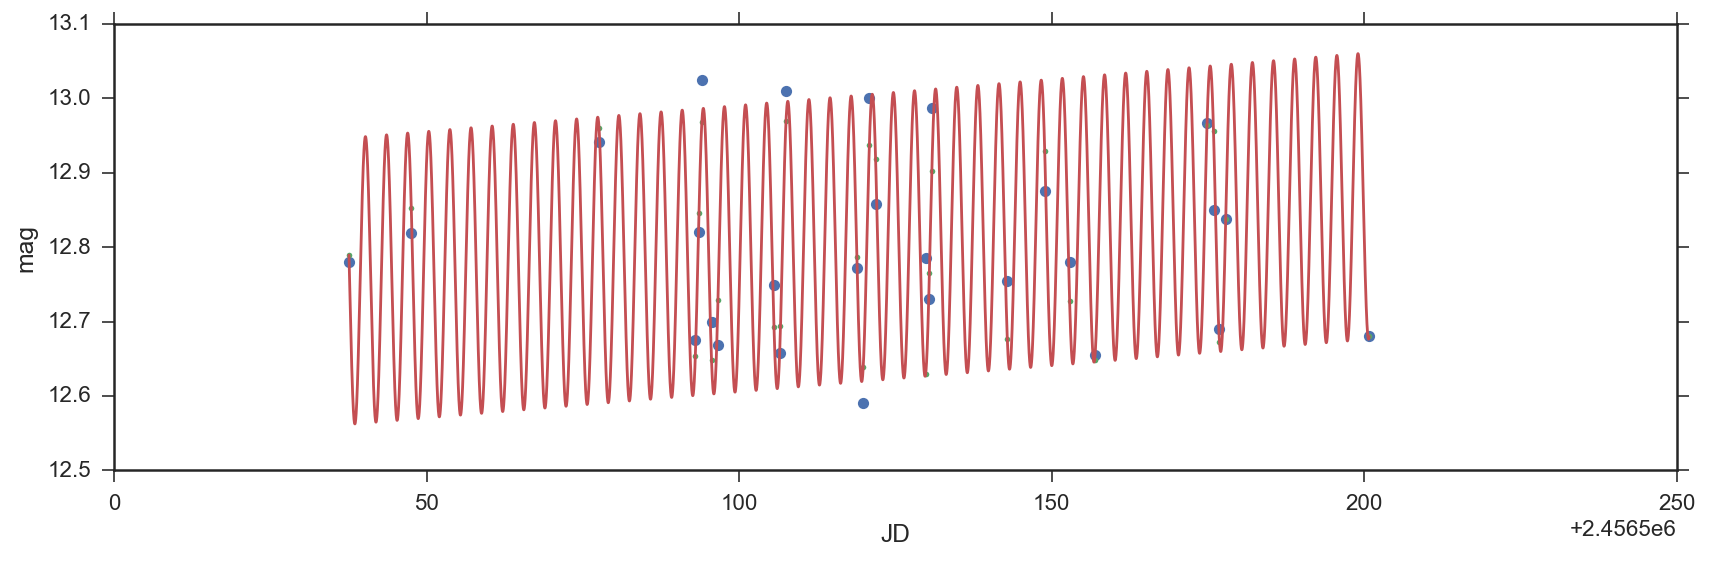

In [28]:
plt.figure(figsize=(14, 4))

plt.plot(x, y, 'o')
plt.plot(x, yfit, '.')
plt.plot(x_dense, yfit_dense)

#plt.xlim(2457200, 2457319+160)
plt.xlabel('JD')
plt.ylabel('mag');

Apply a **multi-term fit** for the periodic component too.

## Do a multi-term fit to the phase-folded data

In [29]:
lc_refined = lc

In [30]:
x = lc_refined.time.values
y = lc_refined.flux.values
yerr = lc_refined.err.values

In [31]:
import astroML.time_series

omega_best = 2.0*np.pi/P_fit
mtf = astroML.time_series.MultiTermFit(omega_best, 3)

In [32]:
phased = np.mod(lc_refined.time.values, P_fit)

In [33]:
mtf_fit = mtf.fit(phased, y, yerr)
phz, phz_yfit = mtf_fit.predict(100, adjust_offset=False)

(13.3, 12.5)

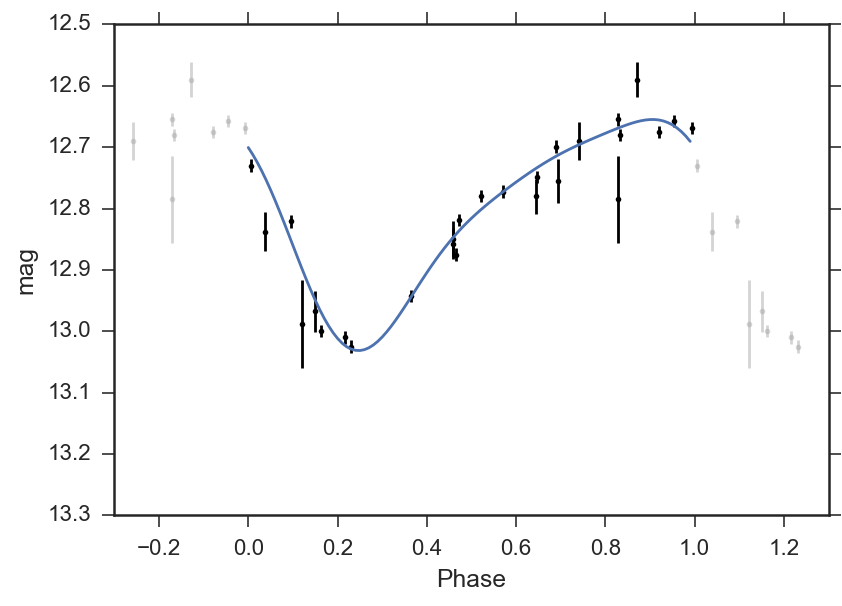

In [34]:
#plt.figure(figsize=(6,6))
    
plt.errorbar(phased/P_fit, y, yerr, fmt='k.')
plt.errorbar(phased/P_fit+1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.errorbar(phased/P_fit-1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('mag')

plt.plot(phz, phz_yfit)

plt.xlim(-0.3, 1.3)
plt.ylim(13.3, 12.5)

## Fit amplitude to aggregated data with errors, and a multiterm fit

In [35]:
M_max = 3 # Number of Fourier components
fourier_cs = np.arange(1,M_max)[:,np.newaxis]

sin_vector = np.sin(fourier_cs*2.0*np.pi*x/P_fit).T
cos_vector = np.cos(fourier_cs*2.0*np.pi*x/P_fit).T

A = np.concatenate((sin_vector,
                    cos_vector,
                    np.vander(x, 3)), axis=1)

In [36]:
ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

yfit = np.matmul(mean_w, A.T)

x_dense = np.arange(x.min(), x.max(), 0.01)

sin_vector_dense = np.sin(fourier_cs*2.0*np.pi*x_dense/P_fit).T
cos_vector_dense = np.cos(fourier_cs*2.0*np.pi*x_dense/P_fit).T

A_dense = np.concatenate((sin_vector_dense,
                    cos_vector_dense,
                    np.vander(x_dense, 3)), axis=1)

yfit_dense = np.matmul(mean_w, A_dense.T)

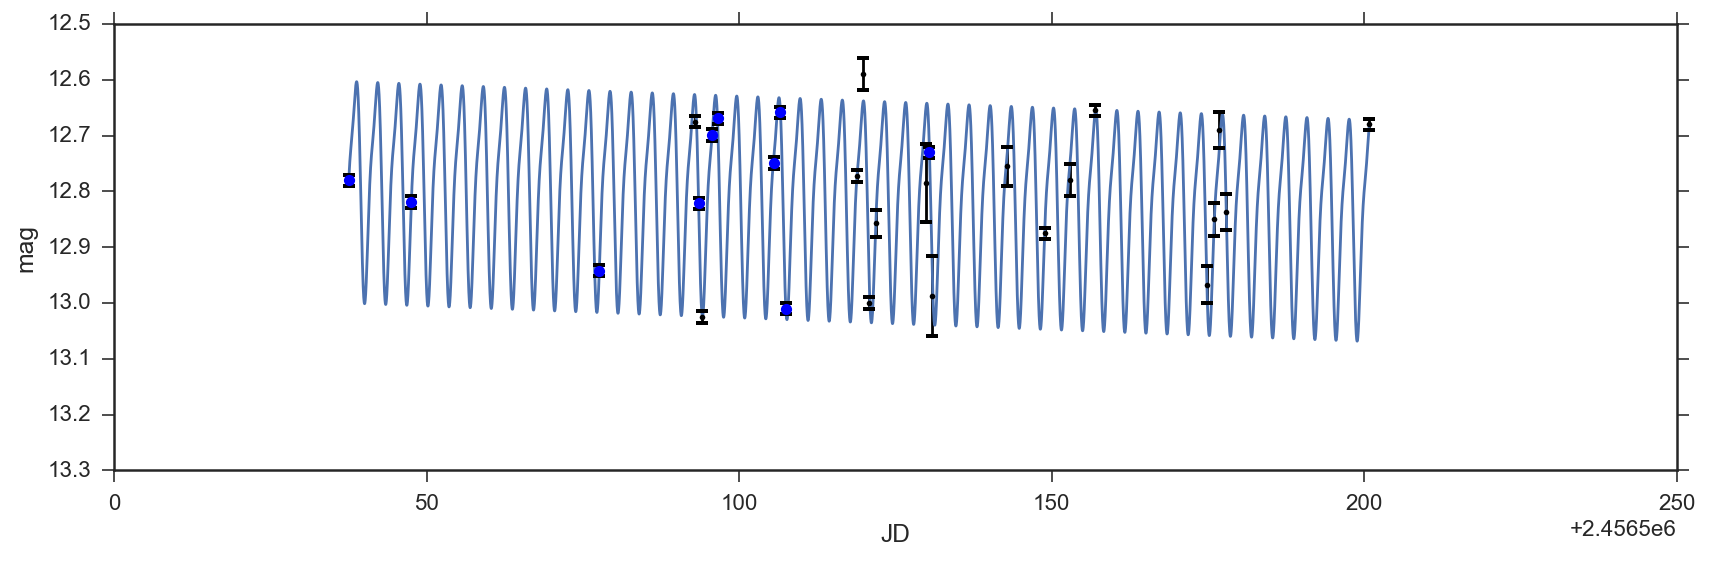

In [37]:
plt.figure(figsize=(14, 4))

#plt.plot(x, y, '.')
#plt.plot(x, yfit, 'o')
plt.plot(x_dense, yfit_dense)
#plt.plot(aggregated_data.JD, aggregated_data.mean_mag, 'ys')
plt.errorbar(x, y, yerr, fmt = 'k.', barsabove=True, capthick=2)

plt.plot(gr_bonus.HJD, gr_bonus.V_mag, 'bo')

#plt.xlim(2457200, 2457319+160)
plt.ylim(13.3, 12.5)
plt.xlabel('JD')
plt.ylabel('mag');

In [38]:
this_phase = np.mod(x, P_fit)/P_fit

(13.3, 12.5)

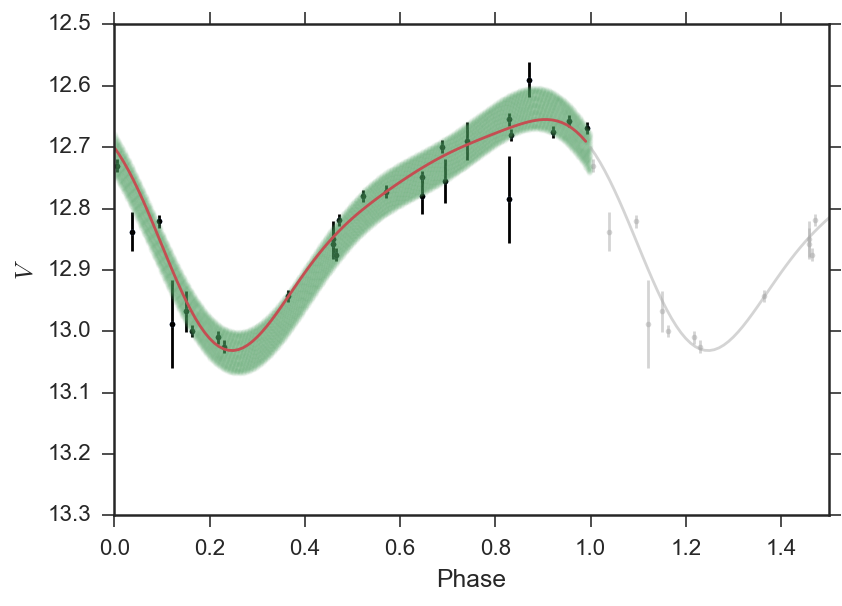

In [39]:
plt.plot(np.mod(x, P_fit)/P_fit, y, '.')

plt.errorbar(phased/P_fit, y, yerr, fmt='k.')
plt.errorbar(phased/P_fit+1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.errorbar(phased/P_fit-1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('$V$')

plt.plot(np.mod(x_dense, P_fit)/P_fit, yfit_dense, '.', alpha=0.05)

plt.plot(phz, phz_yfit)
plt.plot(phz+1, phz_yfit, color='#AAAAAA', alpha=0.5)
plt.plot(phz-1, phz_yfit, color='#AAAAAA', alpha=0.5)

#plt.vlines(phased_IG/P_fit, 12.51, 13.29, linestyles='solid', colors='red')
#plt.vlines(phased_IG2/P_fit, 12.51, 13.29, linestyles='dashed')

#plt.text(phased_IG/P_fit-0.02, 12.49, 'IGRINS JD: {:.3f}'.format(IG_OBS_date1), rotation=40, 
#        verticalalignment='bottom')

#plt.text(phased_IG2/P_fit-0.02, 12.49, 'IGRINS JD: {:.3f}'.format(IG_OBS_date2), rotation=40, 
#        verticalalignment='bottom')

plt.xlim(0.0, 1.5)
plt.ylim(13.3, 12.5)
#plt.savefig('../document/figures/ASASSN_phase_fitted.pdf', bbox_inches="tight")

The green shaded region shows the range of offset attributable to using the underlying polynomial trend.

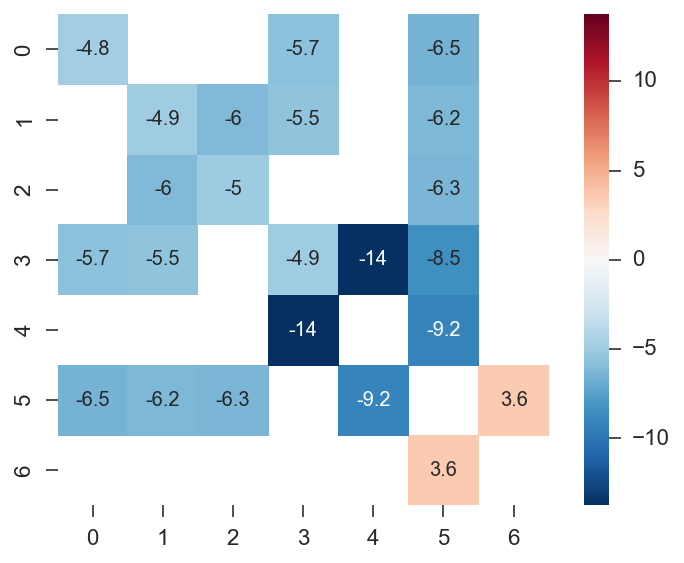

In [40]:
sns.heatmap(np.log10(sigma_w), annot=True, square=True)

Make 100 random draws from the best fit:

In [41]:
vals = np.random.multivariate_normal(mean_w, sigma_w, size=100)

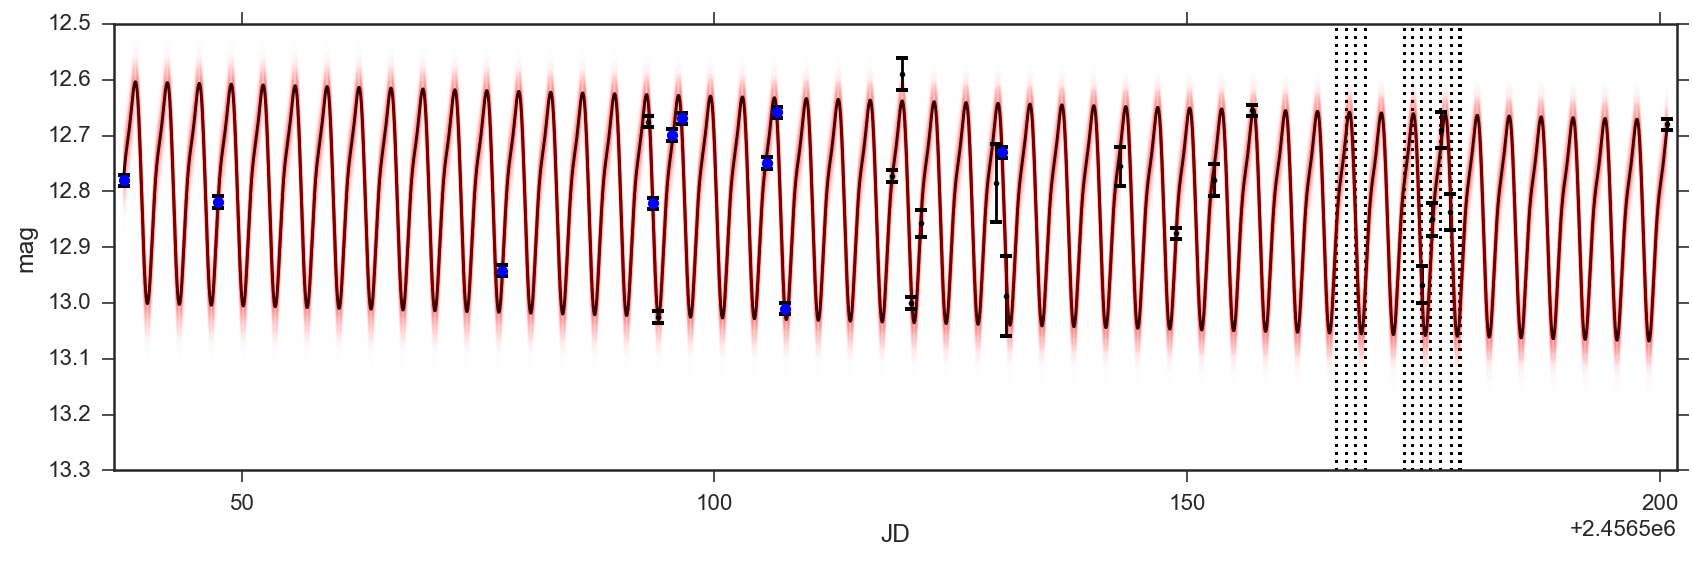

In [42]:
plt.figure(figsize=(14, 4))

#plt.plot(x, y, '.')
#plt.plot(x, yfit, 'o')
plt.plot(x_dense, yfit_dense, 'k')

for i in range(len(vals)):
    yfit_dense = np.matmul(vals[i, :], A_dense.T)
    plt.plot(x_dense, yfit_dense, 'r', alpha=0.01)

#plt.plot(aggregated_data.JD, aggregated_data.mean_mag, 'ys')
plt.errorbar(x, y, yerr, fmt = 'k.', barsabove=True, capthick=2)

plt.plot(gr_bonus.HJD, gr_bonus.V_mag, 'bo')

for i in range(len(espadons_obsdates)):
    plt.vlines(espadons_obsdates.BJD, 13.3, 12.5, linestyles='dotted')

#plt.xlim(2457200, 2457319+160)
plt.ylim(13.3, 12.5)
plt.xlim(x.min()-1, x.max()+1)
plt.xlabel('JD')
plt.ylabel('mag');

Zoom in on the ESPaDoNs Observations.

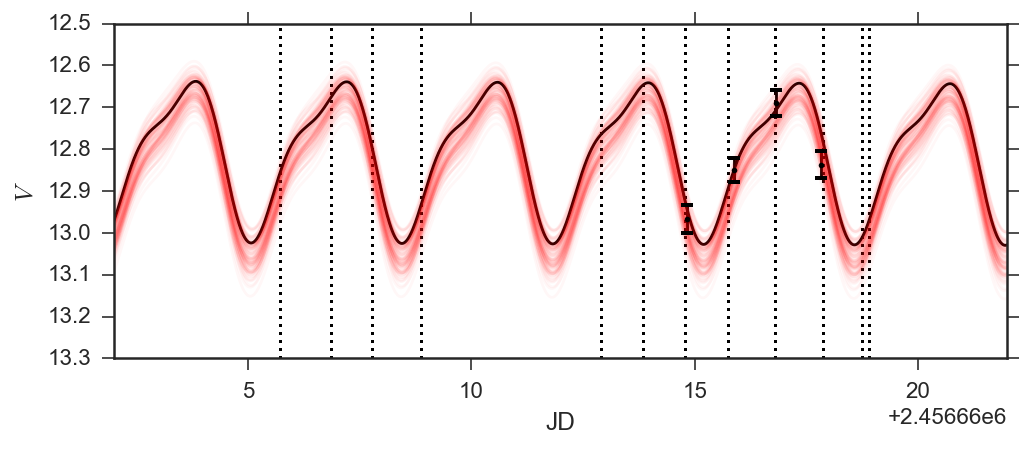

In [59]:
plt.figure(figsize=(8, 3))

#plt.plot(x, y, '.')
#plt.plot(x, yfit, 'o')
plt.plot(x_dense, yfit_dense, 'k')

for i in range(len(vals)):
    yfit_dense = np.matmul(vals[i, :], A_dense.T)
    plt.plot(x_dense, yfit_dense, 'r', alpha=0.03)

#plt.plot(aggregated_data.JD, aggregated_data.mean_mag, 'ys')
plt.errorbar(x, y, yerr, fmt = 'k.', barsabove=True, capthick=2)

plt.plot(gr_bonus.HJD, gr_bonus.V_mag, 'bo')

for i in range(len(espadons_obsdates)):
    plt.vlines(espadons_obsdates.BJD, 13.3, 12.5, linestyles='dotted')

#plt.xlim(2457200, 2457319+160)
plt.ylim(13.3, 12.5)
plt.xlim(2456662, 2456662+20)
plt.xlabel('JD')
plt.ylabel('$V$')
plt.savefig('../document/figures/ESPaDoNs_phot_epochs.pdf', bbox_inches='tight');

The main uncertainty probably comes from the period estimate uncertainty, which is not included here at all!

## Cross validation for complexity of de-trending *and* number $M$ of Fourier components

In [ ]:
from sklearn import cross_validation

In [ ]:
def lin_regress(A, y, yerr):
    ATA = np.dot(A.T, A / yerr[:, None]**2)
    sigma_w = np.linalg.inv(ATA)
    mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))
    return mean_w

In [ ]:
polys = np.arange(1, 8)
net_scores = np.zeros(len(polys))
n_folds = 10

In [ ]:
j = 0
for n_poly in polys:


    X = np.concatenate((sin_vector,
                    cos_vector,
                    np.vander(x, n_poly)), axis=1)
    
    n, n_dim = X.shape
    scores_test = np.zeros(n_folds)

    kf = cross_validation.KFold(n, n_folds=n_folds)
    i = 0
    for train_index, test_index in kf:
        #print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_train_err, y_test_err = yerr[train_index], yerr[test_index]
        w_train = lin_regress(X_train, y_train, y_train_err)
        y_test_fit = np.matmul(w_train, X_test.T)
        resid = np.sqrt(np.sum(((y_test-y_test_fit)/y_test_err)**2))
        scores_test[i] = resid
        i += 1
    net_scores[j] = np.mean(scores_test)
    j += 1

In [ ]:
plt.step(polys[1:], net_scores[1:], where='mid')
plt.xlabel('Polynomial Degree')
plt.plot([polys[np.argmin(net_scores)]], [np.min(net_scores)], 'r*', ms=20, alpha=0.65)
plt.ylabel('Mean Test RMS')

Let's just go with a $3^{rd}$ order polynomial.  What about $M$, the number of Fourier components?

In [ ]:
M_maxes = np.arange(1,14)

In [ ]:
net_scores = np.zeros(len(M_maxes))

In [ ]:
j = 0
for M_max in M_maxes:

    fourier_cs = np.arange(1,M_max)[:,np.newaxis]
    sin_vector = np.sin(fourier_cs*2.0*np.pi*x/P_fit).T
    cos_vector = np.cos(fourier_cs*2.0*np.pi*x/P_fit).T

    X = np.concatenate((sin_vector,
                    cos_vector,
                    np.vander(x, 3)), axis=1)
    
    n, n_dim = X.shape
    scores_test = np.zeros(n_folds)

    kf = cross_validation.KFold(n, n_folds=n_folds)
    i = 0
    for train_index, test_index in kf:
        #print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_train_err, y_test_err = yerr[train_index], yerr[test_index]
        w_train = lin_regress(X_train, y_train, y_train_err)
        y_test_fit = np.matmul(w_train, X_test.T)
        resid = np.sqrt(np.sum(((y_test-y_test_fit)/y_test_err)**2))
        scores_test[i] = resid
        i += 1
    net_scores[j] = np.mean(scores_test)
    j += 1

In [ ]:
plt.step(M_maxes, net_scores, where='mid')
plt.xlabel('$M$ Fourier components')
plt.ylabel('Mean Test RMS')
plt.plot([M_maxes[np.argmin(net_scores)]], [np.min(net_scores)], 'r*', ms=20, alpha=0.65)
plt.yscale('log')

It looks like it prefers $M=3$ Fourier components.

BREAK.

## What happens if you fold in data from the next season?

In [ ]:
inds = (dat.JD > 2456520) & (dat.JD < 2457150)

x = np.append(dat.JD[inds].values, gr_bonus.HJD.values) 
y = np.append(dat.mean_mag[inds].values, gr_bonus.V_mag.values)
yerr = np.append(dat.stddev[inds].values, gr_bonus.err.values)

plt.figure(figsize=(7, 3))
plt.plot(dat.JD, dat.mean_mag, '.', label='All photometry')
plt.plot(x, y, '.', label='Analysis subset')
plt.ylim(13.5, 12.2)
plt.xlim(2455610, 2457800)
    
plt.vlines(2456520, 13.5, 12.2, linestyles='dashed')
plt.vlines(2457150, 13.5, 12.2, linestyles='dashed')
    
plt.legend(loc='lower left')
plt.xlabel('JD')
plt.ylabel('mag');

In [ ]:
phased = np.mod(x, P_fit)

In [ ]:
sns.set_context('notebook')

In [ ]:
plt.plot(np.mod(x, P_fit)/P_fit, y, '.')

plt.errorbar(phased/P_fit, y, yerr, fmt='k.')
plt.errorbar(phased/P_fit+1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.errorbar(phased/P_fit-1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)

plt.xlabel('Phase')
plt.ylabel('$V$')

plt.plot(phz, phz_yfit)
plt.plot(phz+1, phz_yfit, color='#AAAAAA', alpha=0.5)
plt.plot(phz-1, phz_yfit, color='#AAAAAA', alpha=0.5)

plt.vlines(np.mod(espadons_obsdates.BJD[0], P_fit)/P_fit, 12.2, 13.5, linestyles='dotted', colors='gray', label='ESPaDoNs spectra (12)')
for i in np.arange(1, len(espadons_obsdates)-1):
    plt.vlines(np.mod(espadons_obsdates.BJD[i], P_fit)/P_fit, 12.2, 13.5, linestyles='dotted', colors='gray')

plt.xlim(-0.3, 1.3)
plt.ylim(13.1, 12.5)
#plt.savefig('../document/figures/ASASSN_phase_fitted.pdf', bbox_inches="tight")

## What if we force the period used in 2015 data?

In [ ]:
P_fit

In [ ]:
this_P_fit = 3.3791479147914791

In [ ]:
P_fit = 3.3749114970499017

In [ ]:
phased = np.mod(x, P_fit)

In [ ]:
plt.plot(np.mod(x, P_fit)/P_fit, y, '.')

plt.errorbar(phased/P_fit, y, yerr, fmt='k.')
plt.errorbar(phased/P_fit+1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.errorbar(phased/P_fit-1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)

plt.xlabel('Phase')
plt.ylabel('$V$')

plt.plot(phz, phz_yfit)
plt.plot(phz+1, phz_yfit, color='#AAAAAA', alpha=0.5)
plt.plot(phz-1, phz_yfit, color='#AAAAAA', alpha=0.5)

plt.vlines(np.mod(espadons_obsdates.BJD[0], P_fit)/P_fit, 12.2, 13.5, linestyles='dotted', colors='gray', label='ESPaDoNs spectra (12)')
for i in np.arange(1, len(espadons_obsdates)-1):
    plt.vlines(np.mod(espadons_obsdates.BJD[i], P_fit)/P_fit, 12.2, 13.5, linestyles='dotted', colors='gray')

plt.xlim(-0.3, 1.3)
plt.ylim(13.1, 12.5)
#plt.savefig('../document/figures/ASASSN_phase_fitted.pdf', bbox_inches="tight")

# The end.